<a href="https://colab.research.google.com/github/EWECORP/DScience_41870/blob/main/Desafio_CrossValidation_Eduardo_Ettlin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

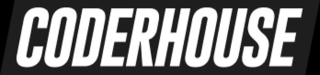

# **CURSO DE DATA SCIENCE**

# **DESAFIO  CROSS VALIDATION**

# **DESAFIO N° 15**

*AUTOR:Eduardo ETTLIN*

Entrenar uno de los modelos elegidos con las mismas variables pero aplicando alguno de los métodos aprendidos de validación cruzada

Describir si hay cambios en el performance del modelo y explicar con razones el porqué

Se recomienda utilizar entre 5-10 folds para el proceso de CrossValidation con el fin de optimizar el tiempo de ejecución de la técnica


In [ ]:
  #Conectamos mi drive
  from google.colab import drive
  #Importamos OS
  import os
  #Montamos drive
  drive.mount('/content/gdrive', force_remount=True)
# Establecer ruta de acceso en drive
import os
print(os.getcwd())

Mounted at /content/gdrive
/content


In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ==============================================================================
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score,silhouette_samples,calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install featuretools -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 618.3/618.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 11.0 MB/s eta 0:00:00


In [ ]:
# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling
import lightgbm as lgb

# utilities
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

# memory management
import gc

In [ ]:
# Me muevo a la carpeta
os.chdir("/content/gdrive/MyDrive/DScience_41870")
print(os.getcwd())

#Lectura del dataframe
datos=pd.read_csv('/content/gdrive/MyDrive/DScience_41870/US_Accidents_Dec21_updated.csv',sep=',',nrows=2845000)  # nrows: 1500000  # Disminuir Tamaño a 1.5 MM (Riginalmente Tiene 2.845.342 registros)

/content/gdrive/MyDrive/DScience_41870


In [ ]:
datos.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


# REDUCCIÓN DEL DATASET - Es Muy Grande para PROCESARLO

Se utilizara la función sample para muestrear todo el DataSet.

PROBAR RANDOMIZED SEARCH
HYPER OPT
BAYES GRID SEARCH (Probabilisticos)

In [ ]:
df= datos.sample(10000)   # Achicar el Set de Datos porque no alcanza a calcular.

In [ ]:
df.Severity.unique()

array([4, 2, 3, 1])

In [ ]:
df.shape

(10000, 47)

# Enriquecer el Modelo
Con variables derivadas de las existentes

In [ ]:
df['Hora'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.hour  # Extraer la HORA del Día en la
df['Anio_Mes'] =  pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%Y-%m')  # Extraer AÑO y MES

df['day_of_week'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana
days = {0:'Lunes',1:'Martes',2:'Miércoeles',3:'Jueves',4:'Viernes',5:'Sabado',6:'Domingo'}
df['day_of_week'] = df['day_of_week'].apply(lambda x: days[x])

df['Mes'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES


In [ ]:

df['DiaS'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.dayofweek  # Dia de la Semana

In [ ]:
## Identificar la Estación Climática

def estacion_climatica(mes):
  if mes.lower() in ('january','february','march'):
    return 'Invierno'
  elif mes.lower() in ('april','may','june'):
    return 'Primavera'
  elif mes.lower() in ('july','august','september'):
    return 'Verano'
  else:
    return 'Otoño'

In [ ]:
df['estacion_meteorologica'] = pd.to_datetime( df['Start_Time'],format='%Y-%m-%d %H:%M:%S').dt.strftime('%B')  # Extraer Nombre del MES
df['estacion_meteorologica'] = df['estacion_meteorologica'].apply(estacion_climatica)

In [ ]:
df.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Hora', 'Anio_Mes', 'day_of_week', 'Mes',
       'DiaS', 'estacion_meteorologica'],
      dtype='object')

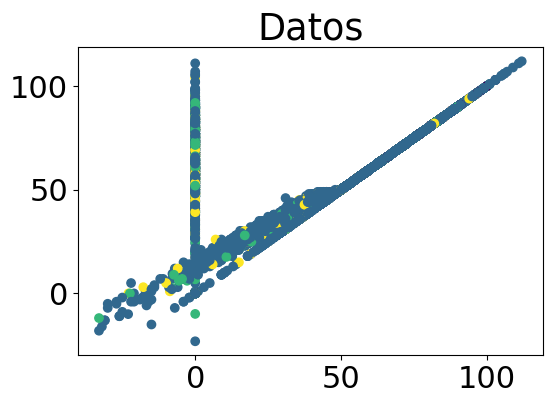

In [ ]:
#Visualizacion!
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(df['Wind_Chill(F)'], df['Temperature(F)'], c=df.Severity);
ax.set_title("Datos");

In [ ]:
# Reemplazo de los vacíos
X = df.fillna(0, inplace=True)

In [ ]:
#Separamos en X e y
X = df.drop(["Severity"], axis=1)
y = df["Severity"]

In [ ]:
# Separar en train y test
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)

(7000, 52) (3000, 52)


In [ ]:
X_train

,ID,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Hora,Anio_Mes,day_of_week,Mes,DiaS,estacion_meteorologica
2507207,A-2507208,2019-03-21 19:21:25,2019-03-21 23:21:25,44.977260,-122.991230,44.964130,-122.990310,0.908,At OR-213/Market St/Exit 256 - Accident.,0.0,...,Day,Day,Day,Day,19,2019-03,Jueves,March,3,Invierno
1797566,A-1797567,2020-12-29 20:13:42,2020-12-29 21:51:06,30.131882,-97.799102,30.145702,-97.793852,1.005,Incident on I-35 NB near ONION CREEK PKY Drive...,0.0,...,Night,Night,Night,Night,20,2020-12,Martes,December,1,Otoño
880035,A-880036,2021-07-25 17:00:30,2021-07-25 19:22:20,36.903941,-76.498165,36.899372,-76.499195,0.321,Stationary traffic on US-17 S from Upton Pl to...,1717.0,...,Day,Day,Day,Day,17,2021-07,Domingo,July,6,Verano
340084,A-340085,2021-08-08 01:33:00,2021-08-08 02:18:30,43.017408,-83.691964,43.014068,-83.689147,0.271,Stationary traffic from M L King Ave/W 1st Ave...,330.0,...,Night,Night,Night,Night,1,2021-08,Domingo,August,6,Verano
2805155,A-2805156,2019-06-11 19:06:02,2019-06-11 19:35:01,42.202240,-87.834310,42.199800,-87.832730,0.187,At IL-22/Half Day Rd - Accident.,0.0,...,Day,Day,Day,Day,19,2019-06,Martes,June,1,Primavera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2092907,A-2092908,2020-04-30 08:50:30,2020-04-30 09:20:30,39.761350,-84.266220,39.761350,-84.266220,0.000,At OH-49 - Accident.,4699.0,...,Day,Day,Day,Day,8,2020-04,Jueves,April,3,Primavera
1077418,A-1077419,2021-12-10 02:38:30,2021-12-10 03:12:00,39.112090,-94.564874,39.106983,-94.569779,0.440,Slow traffic on I-35 S - US-71 S - I-29 S from...,0.0,...,Night,Night,Night,Night,2,2021-12,Viernes,December,4,Otoño
1949512,A-1949513,2020-12-02 14:27:00,2020-12-02 17:50:36,37.089843,-121.596498,37.089946,-121.596200,0.018,Incident on E SAN MARTIN AVE near SYCAMORE AVE...,0.0,...,Day,Day,Day,Day,14,2020-12,Miércoeles,December,2,Otoño
655521,A-655522,2021-06-18 13:39:35,2021-06-18 19:35:11,41.377505,-74.103244,41.408735,-74.077404,2.540,Crash on I-87 - NYS Thruway northbound at Afte...,0.0,...,Day,Day,Day,Day,13,2021-06,Viernes,June,4,Primavera


In [ ]:
y_train

2507207    2
1797566    2
880035     2
340084     2
2805155    3
          ..
2092907    2
1077418    2
1949512    2
655521     2
359708     2
Name: Severity, Length: 7000, dtype: int64

In [ ]:
y_train

array([1, 1, 1, ..., 1, 1, 1])

# Seleccion manual

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [ ]:
model= xgb.XGBClassifier(learning_rate=0.001)
# Lista de hiperparametros
params_1 = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5}
params_2 = {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 7}
params_3 = {'criterion': 'gini', 'splitter': 'random', 'max_depth': 10}

## Estos procesos pueden demorar bastante !!

In [ ]:
# División de los datos en train y test
X = df.drop(columns = ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng','End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone','Airport_Code', 'Weather_Timestamp',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Hora', 'Anio_Mes', 'day_of_week', 'Mes', 'DiaS', 'estacion_meteorologica',
       'Astronomical_Twilight'], axis= 1) # Matriz de 2 columnas -Variable Independientes # 'Temperature(F)', 'Wind_Chill(F)',
y = df['Severity'] # Vector de 200 filas y 1 columna- Variable Dependiente

In [ ]:
#Visualizar X
X

,Temperature(F),Wind_Chill(F)
2680899,62.6,0.0
588348,59.0,59.0
70884,78.8,0.0
1865131,82.0,82.0
993247,44.0,44.0
...,...,...
1704112,73.0,73.0
818892,75.0,75.0
1270008,0.0,0.0
664669,59.0,59.0


In [ ]:
#Visualizar y
y

2680899    4
588348     2
70884      2
1865131    2
993247     2
          ..
1704112    2
818892     2
1270008    2
664669     2
469357     2
Name: Severity, Length: 10000, dtype: int64

In [ ]:
 y.values.reshape(-1,1)

array([[4],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

# Grid Search

In [ ]:
params_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [5,6,7],
        'criterion':['entropy','gini']
        }

In [ ]:
# tiempo de ejecucuon 424 seg
grid_cv = GridSearchCV(model, params_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_cv.fit(X_train, y_train)

print("Mejores Parametros", grid_cv.best_params_)
print("Mejor CV score", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(X_test)), 5)}')

ValueError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y.values.reshape(-1,1),train_size= 0.75,\
                                                    random_state = 42,shuffle=True)

# Randomized Search CV

In [ ]:
# tiempo de ejecucuon 7 seg
grid_cv = RandomizedSearchCV(model, params_grid, scoring="accuracy", n_jobs=-1, cv=3)
grid_cv.fit(X_train, y_train)

print("Mejores parametros", grid_cv.best_params_)
print("Mejor score de CV", grid_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, grid_cv.predict(X_test)), 5)}')

ValueError: ignored

# Halving Grid Search

In [ ]:
# tiempo de ejecucuon 125 seg
halving_cv = HalvingGridSearchCV(model, params_grid, scoring="accuracy", factor=3)
halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor Score CV", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')

# Halving Randomized Search

In [ ]:
# tiempo de ejecucuon 13 seg
halving_cv = HalvingRandomSearchCV(model, params_grid, scoring="accuracy", factor=3)
halving_cv.fit(X_train, y_train)

print("Mejores parametros", halving_cv.best_params_)
print("Mejor CV score", halving_cv.best_score_)
print(f'Accuracy del modelo = {round(accuracy_score(y_test, halving_cv.predict(X_test)), 5)}')

In [ ]:
#Calculo el accuracy en Test
from sklearn.metrics import accuracy_score
test_accuracy = accuracy_score(y_test, y_test_pred)
print('% de aciertos sobre el set de evaluación:',test_accuracy)

NameError: ignored

# **Inicio de Feature Selection**

Debe hacerse con muchos menos registros para optimizar la capacidad de cálculo y la visualización

In [ ]:
df_filtered= datos.sample(200)   # Achicar el Set de Datos porque no alcanza a calcular.

In [ ]:
# Reemplazo de los vacíos
X = df_filtered.fillna(0, inplace=True)

In [ ]:
df_filtered.Severity.unique()

array([2, 4, 3, 1])

In [ ]:
df_filtered.shape


(200, 47)

In [ ]:
X

,Temperature(F),Wind_Chill(F)
301138,0.0,0.0
19702,64.9,0.0
2814409,71.0,71.0
2574045,52.5,0.0
2748002,54.0,0.0
...,...,...
1321496,36.0,31.0
183605,55.4,0.0
69365,77.0,0.0
1142337,71.0,71.0


In [ ]:
y

301138     2
19702      2
2814409    2
2574045    4
2748002    2
          ..
1321496    2
183605     2
69365      2
1142337    2
677271     2
Name: Severity, Length: 200, dtype: int64

In [ ]:
# normalizar data
#X = df_filtered.values
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)

In [ ]:
X

array([[-2.90835498, -1.61932268],
       [ 0.16761426, -1.61932268],
       [ 0.45672693,  0.67104567],
       [-0.42009019, -1.61932268],
       [-0.34899691, -1.61932268],
       [ 0.78849556,  0.89685663],
       [-0.34899691,  0.12264761],
       [ 1.30984628,  1.25170243],
       [ 1.02547316,  1.05815018],
       [ 0.83589108,  0.92911534],
       [-0.39639243,  0.0903889 ],
       [ 0.93068212,  0.99363276],
       [ 0.12495829,  0.4452347 ],
       [-1.81825802, -1.19995946],
       [ 1.02547316,  1.05815018],
       [ 1.30984628,  1.25170243],
       [ 0.31454037, -1.61932268],
       [-2.05523562, -1.33867191],
       [ 0.78849556,  0.89685663],
       [-1.58128042, -1.07092462],
       [ 0.46146648, -1.61932268],
       [-0.49118347,  0.02587148],
       [ 0.93068212,  0.99363276],
       [-1.34430283, -0.68382012],
       [-1.7708625 , -1.19995946],
       [-0.25420587,  0.18716503],
       [-0.15941483,  0.25168245],
       [-0.30160139,  0.15490632],
       [-3.1927281 ,

In [ ]:
# diccionarios vacios para ser almacenados los resultados
sse,db,slc,cal = {}, {}, {}, {}
for k in range(2, 10):
    # semilla de 10 para asegurar reproducibilidad
    kmeans = KMeans(n_clusters=k, max_iter=1000,random_state=10).fit(X) # Algoritmo K means
    if k == 3: labels = kmeans.labels_
    clusters = kmeans.labels_ # Extraccion de labels
    sse[k] = kmeans.inertia_ # Inercia: Suma de las distancias de las muestras a su centroide mas cercano
    db[k] = davies_bouldin_score(X,clusters) # Calculo del indice de Davies Bouldin
    slc[k] = silhouette_score(X,clusters) # Calculo del indice de Silhouette
    cal[k] = calinski_harabasz_score(X,clusters) # Calculo del indice de Calinski-Harabasz

Para n_clusters = 2 El promedio del score de silhouette es:  0.5135846743182573
Para n_clusters = 3 El promedio del score de silhouette es:  0.5660256997306674
Para n_clusters = 4 El promedio del score de silhouette es:  0.5981430317637603
Para n_clusters = 5 El promedio del score de silhouette es:  0.5906692160469796
Para n_clusters = 6 El promedio del score de silhouette es:  0.5802819086777107
Para n_clusters = 7 El promedio del score de silhouette es:  0.5854246054844654
Para n_clusters = 8 El promedio del score de silhouette es:  0.5943864010728339
Para n_clusters = 9 El promedio del score de silhouette es:  0.565136437049115


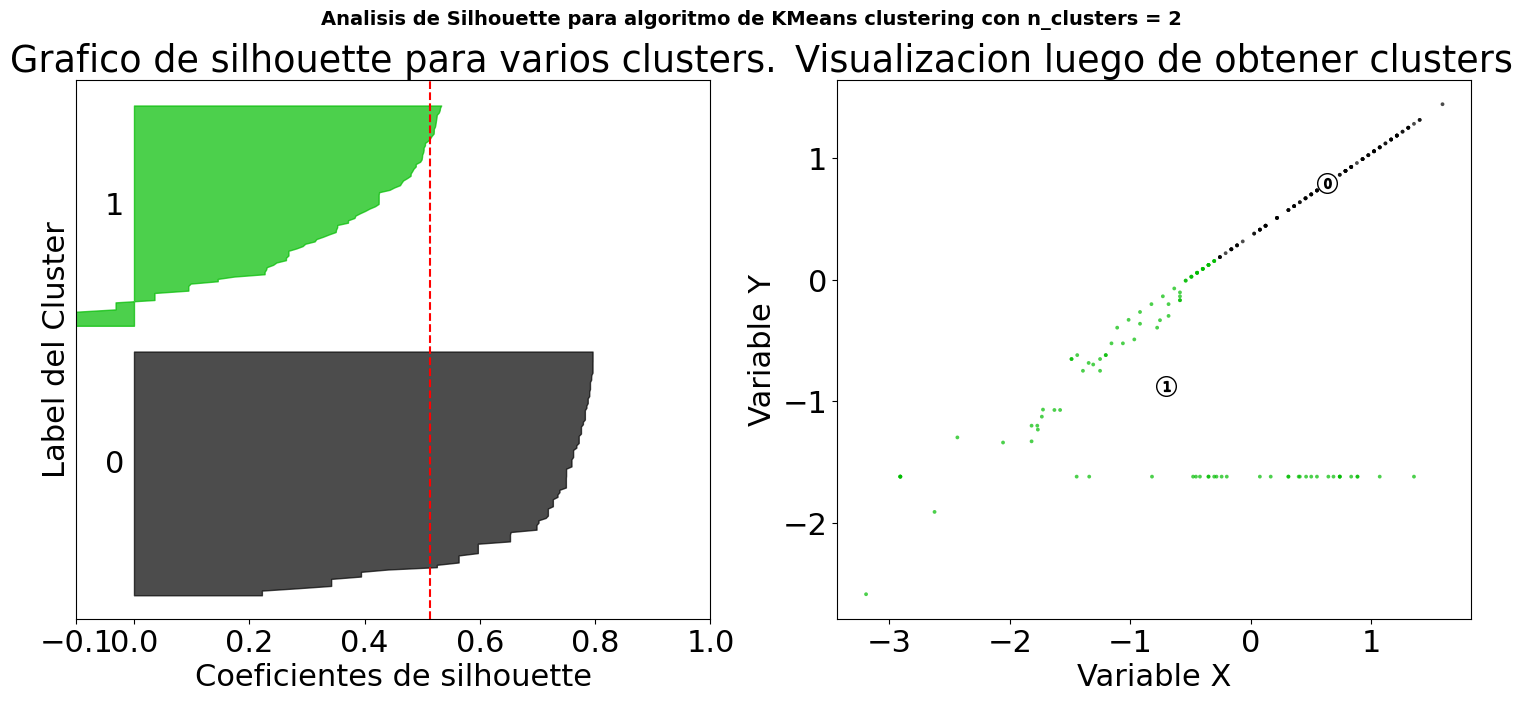

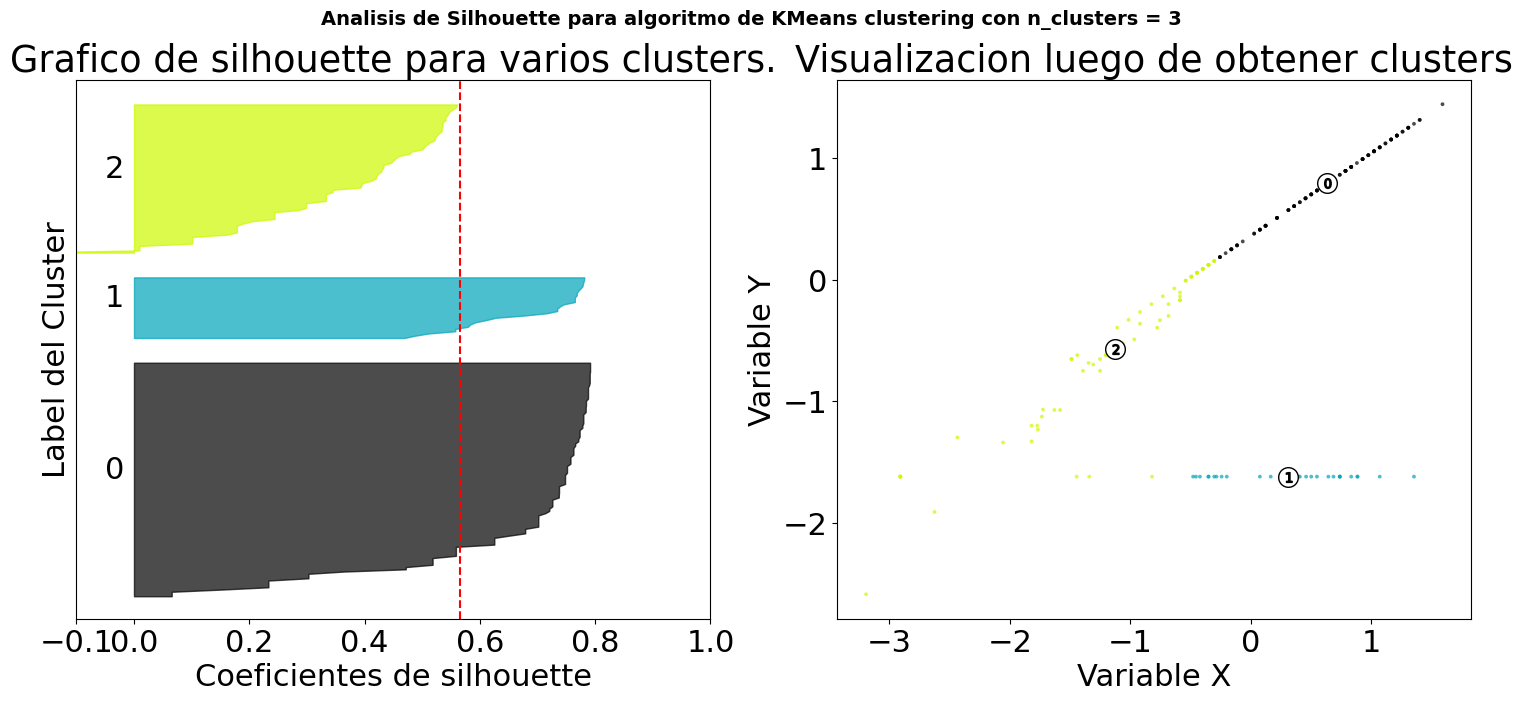

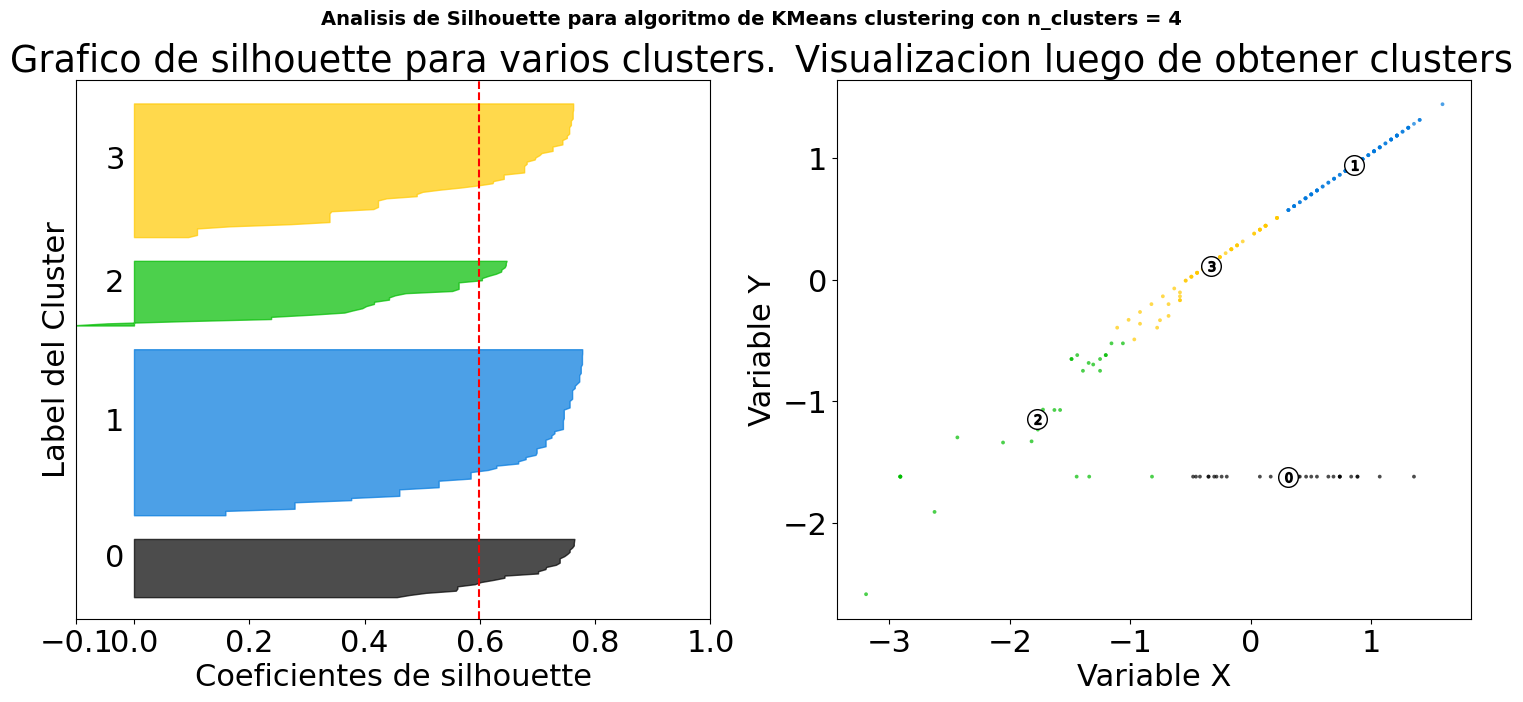

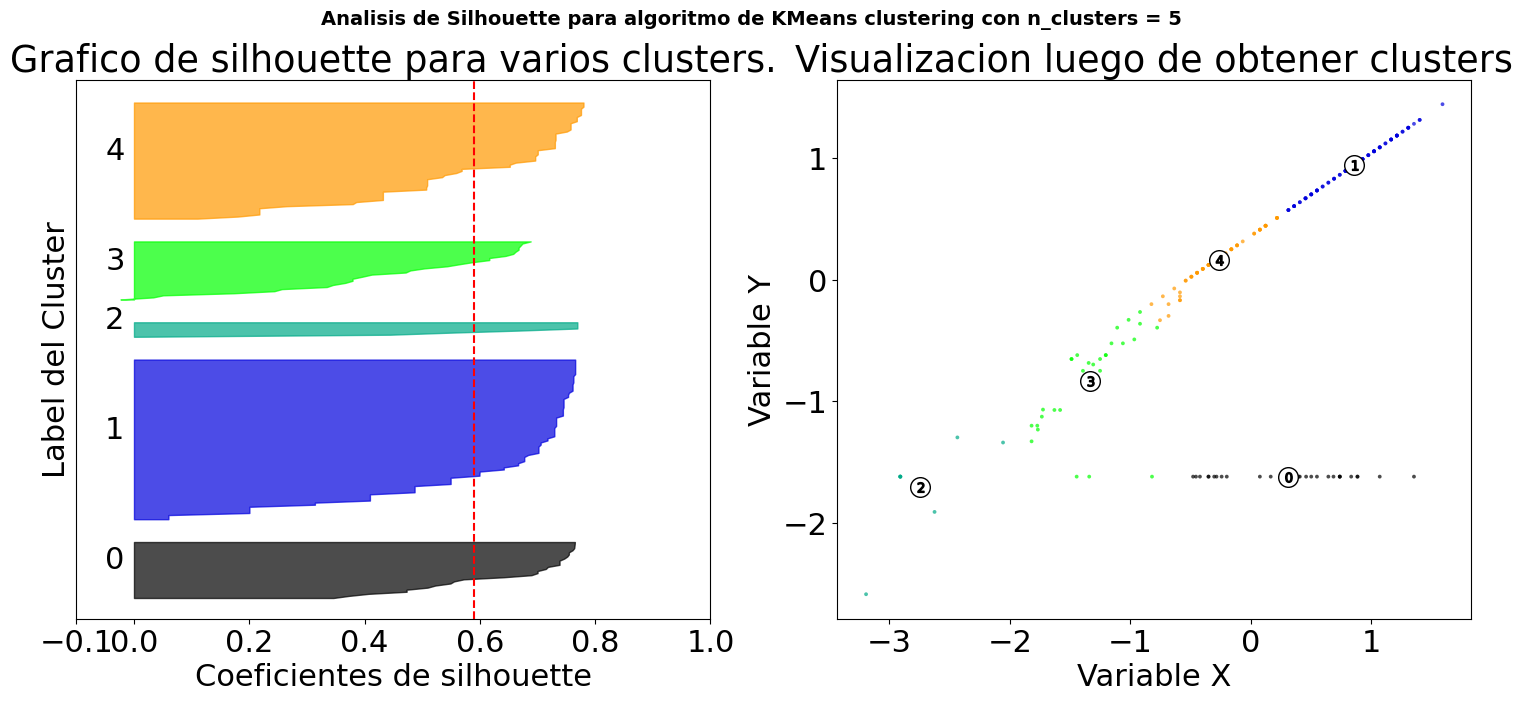

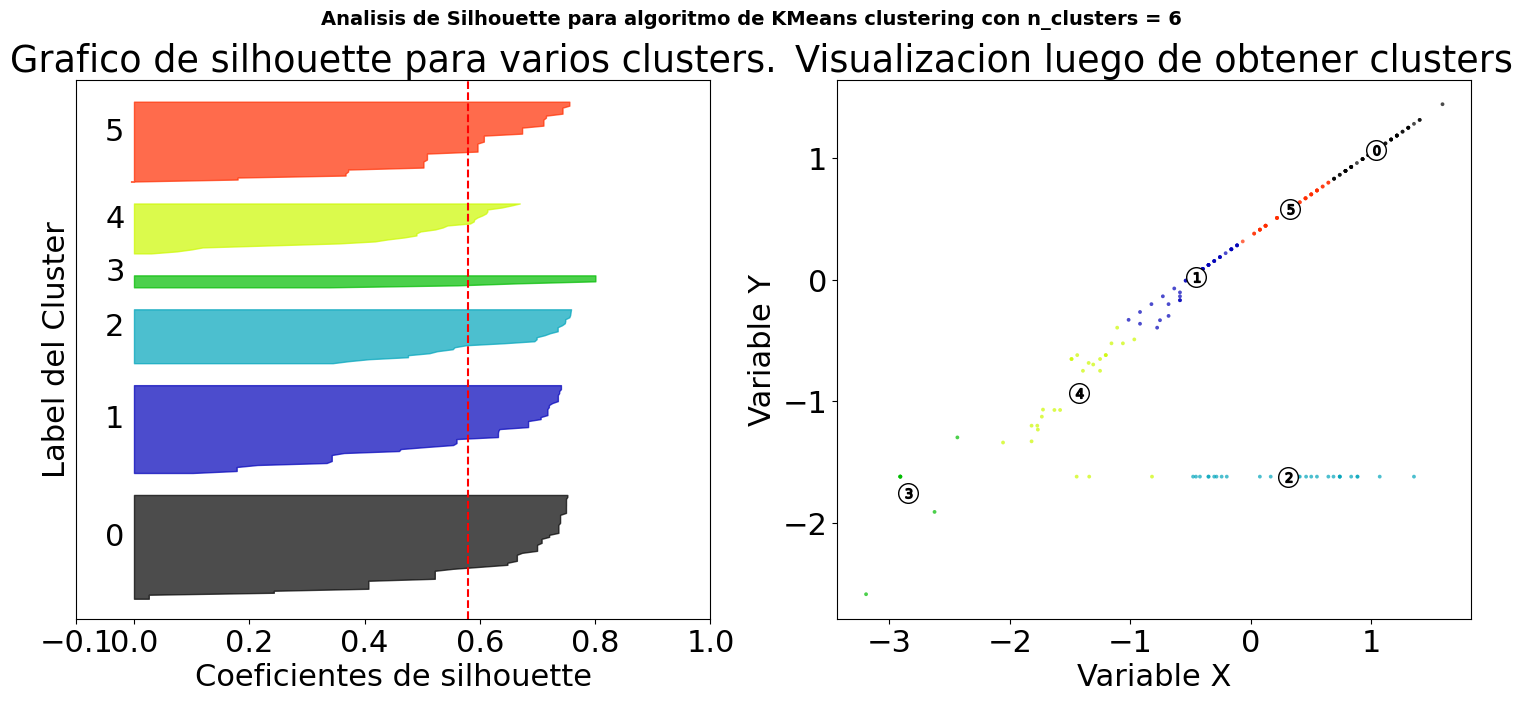

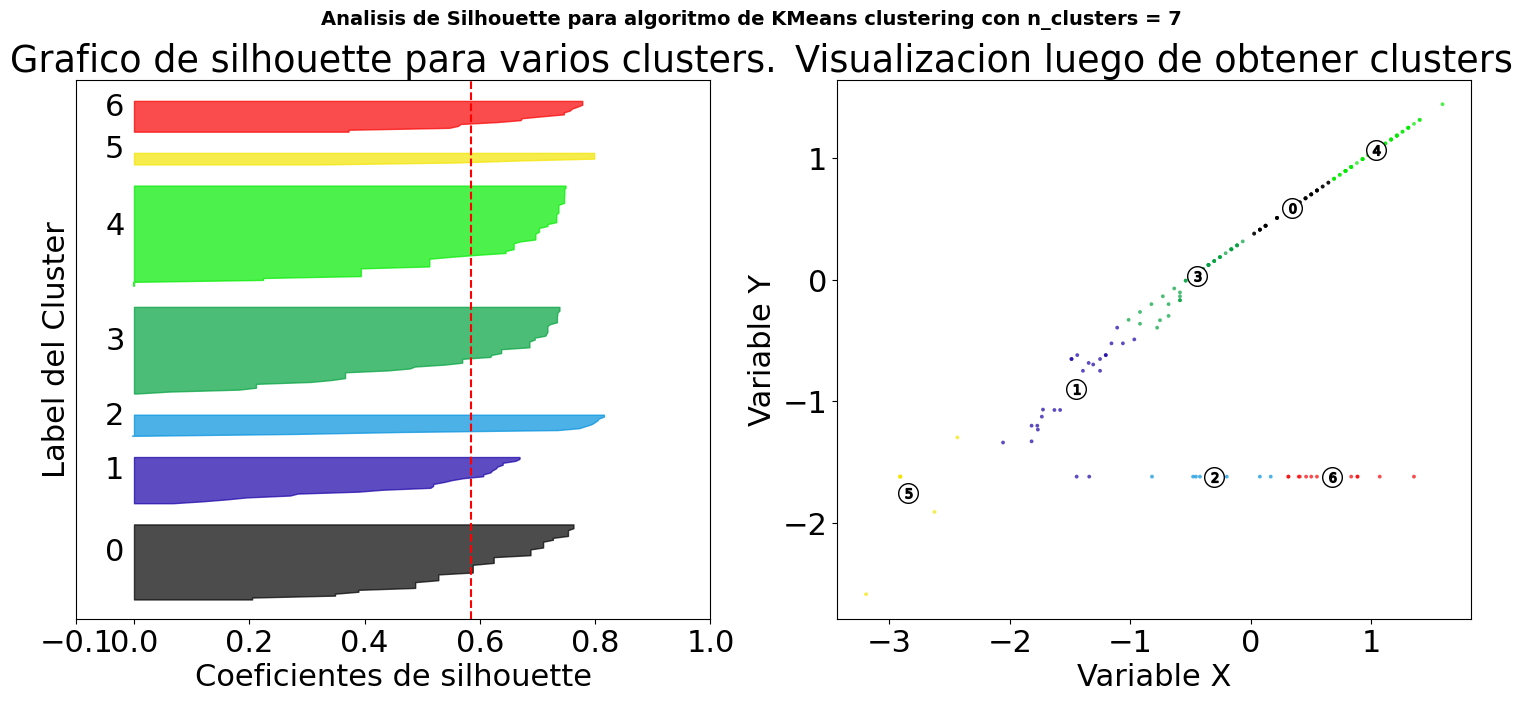

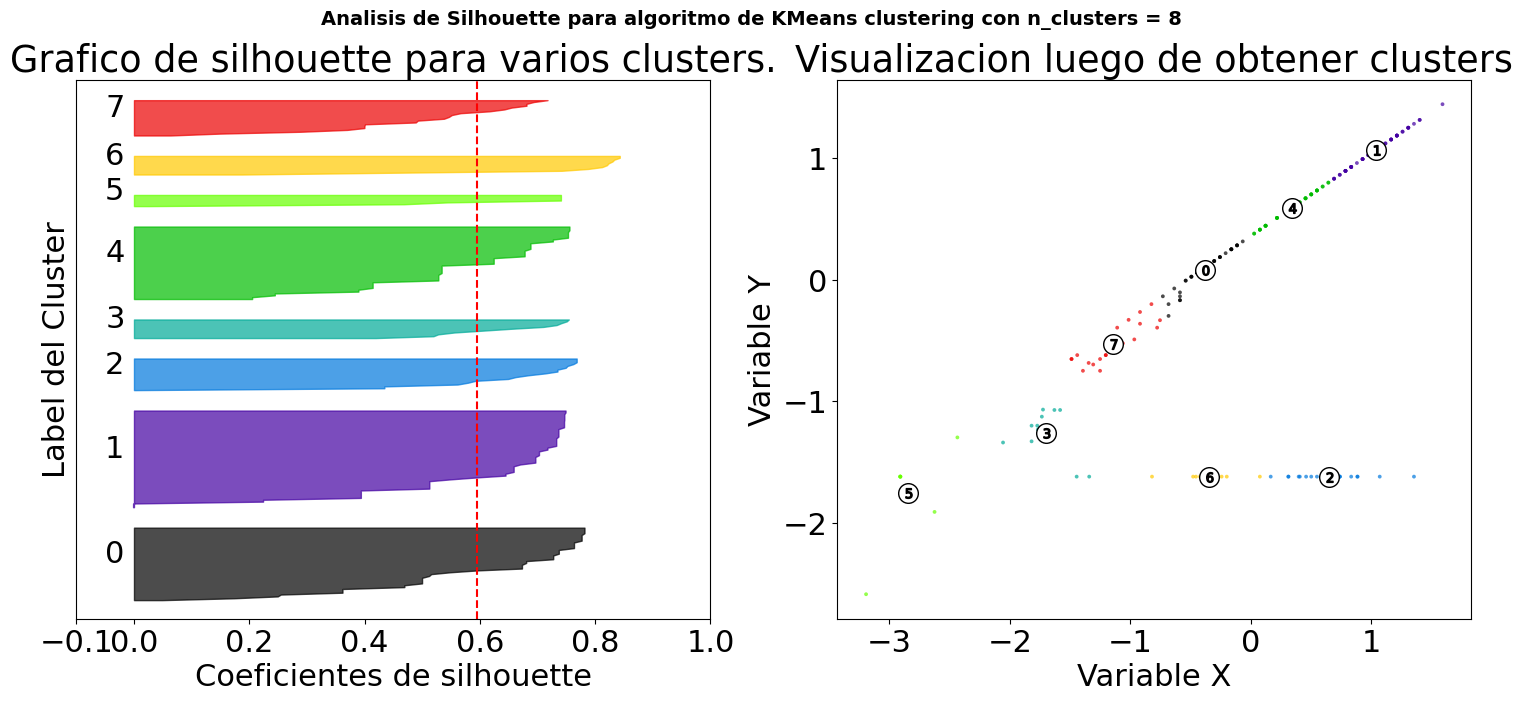

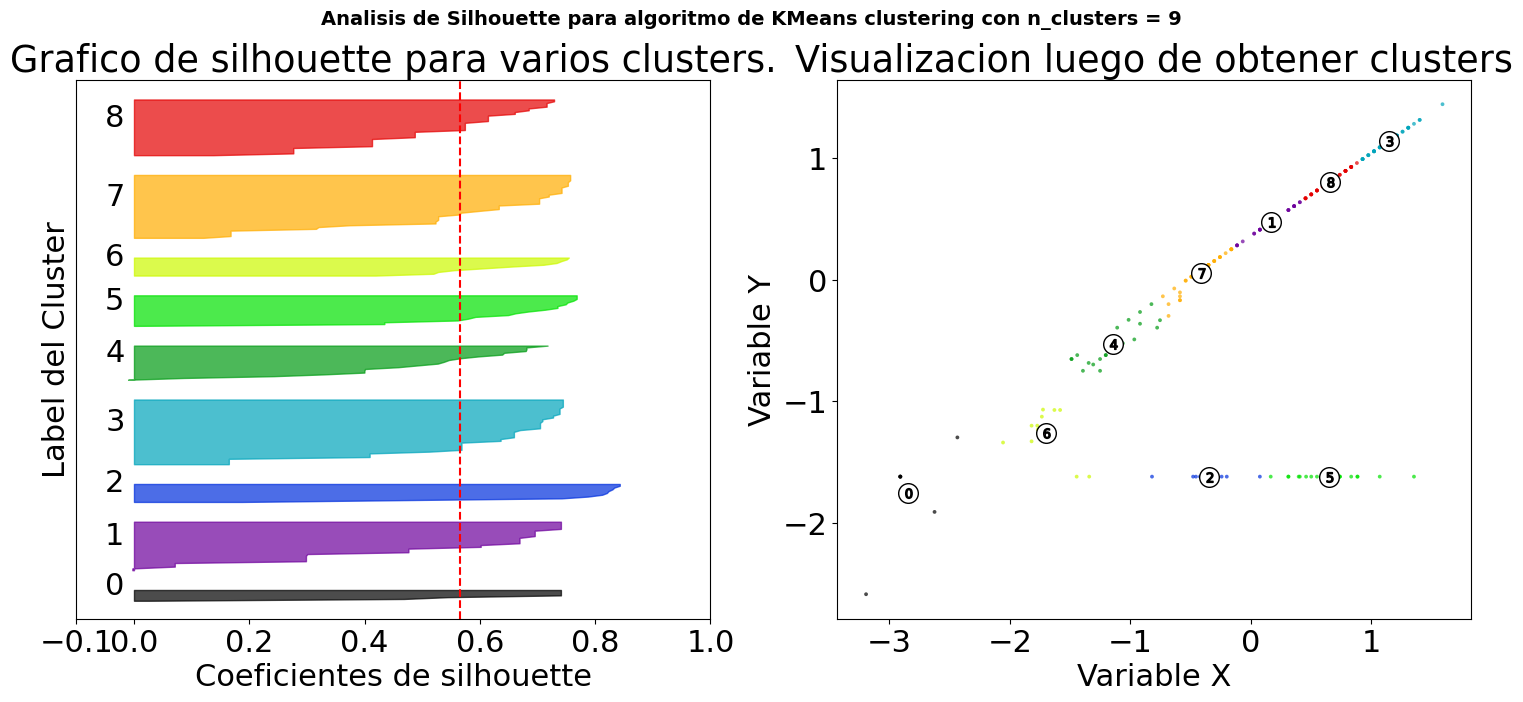

In [ ]:
for n_clusters in range(2, 10):
    # Crear un subplot de 1 fila y 2 columnas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    # El 1 subplot es para el score de silhouette
    # El rango del Ind. silhouette es [-1, 1]
    ax1.set_xlim([-0.1, 1]) # para nuestro caso lo voy a dejar en este rango
    # El (n_clusters+1)*10 es para insertar un espacio en blanco entre la silueta
     # y el grafico de la nube de puntos
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    # Iniciamos el proceso de ajuste a los datos
    clusterer = KMeans(n_clusters=n_clusters,max_iter=1000, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    # El score de silhouette_score da el promedio de todos los valores
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El promedio del score de silhouette es: ", silhouette_avg)
    # Calcular el score de silhouette para cada muestra
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregar los scores de silhouette para las muestras pertenecientes al cluster i y ordenarlos
        ith_cluster_silhouette_values =sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort() # Ordenar
        size_cluster_i = ith_cluster_silhouette_values.shape[0] # Tamaño de clusters
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters) # Definir paleta de colores
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        # Etiquetar las graficas de silhouette con sus miembros de cluster en el medio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        # Calcular el nuevo y_lower para la proxima grafica
        y_lower = y_upper + 10
    ax1.set_title("Grafico de silhouette para varios clusters.")
    ax1.set_xlabel("Coeficientes de silhouette")
    ax1.set_ylabel("Label del Cluster")
    # La linea vertical para el promedio del score de silhouette de todos los valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Quitar labels en y
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) # definir ticks para comparacion

    # 2 grafica mostrando los clusters formados
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters) # definir colores
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k') # scatterplot
    # Etiquetar a los clusters
    centers = clusterer.cluster_centers_
    # Dibujar en color blanco los centroides de los clusters
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')
    # Enumerar los centroides
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

    ax2.set_title("Visualizacion luego de obtener clusters")
    ax2.set_xlabel("Variable X")
    ax2.set_ylabel("Variable Y")

    plt.suptitle(("Analisis de Silhouette para algoritmo de KMeans clustering "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Graficar Clusters para K = 3

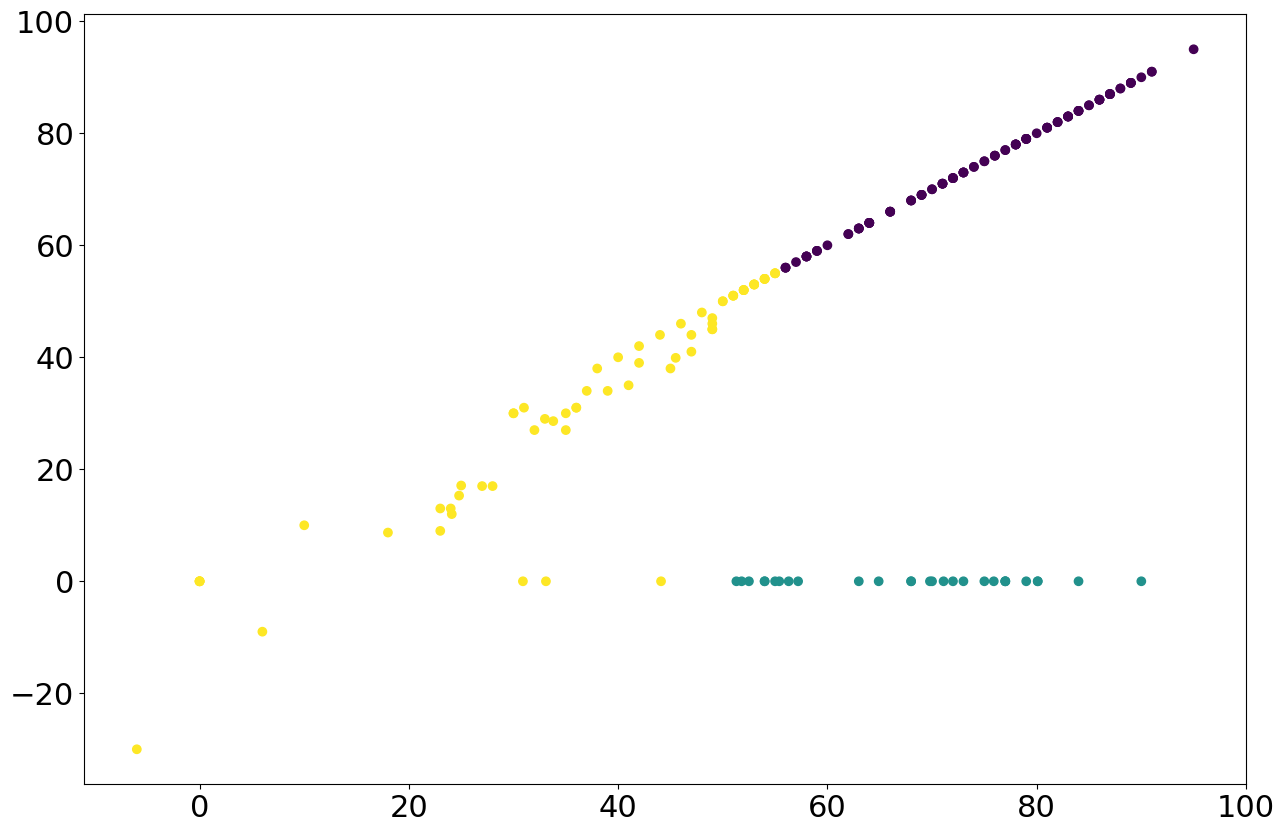

In [ ]:
# desnormalizar los datos
X = sc.inverse_transform(X)
plt.figure(figsize=(15,10))
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()